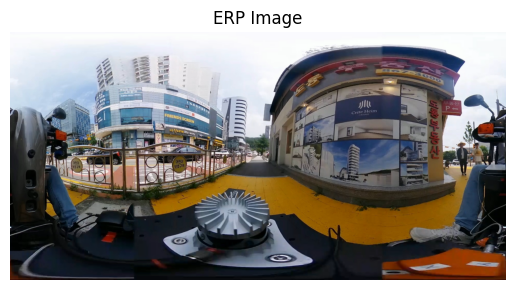

In [1]:
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np

path = os.getcwd()
file = "./erp.png"

# Load the ERP image
erp_image = cv2.imread(file)
erp_image = cv2.cvtColor(erp_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Display the ERP image
plt.imshow(erp_image)
plt.title('ERP Image')
plt.axis('off')  # Do not show axis labels and ticks
plt.show()


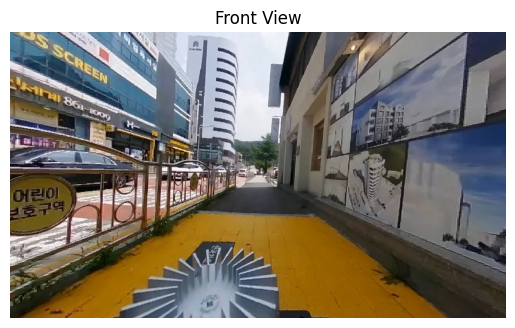

In [6]:
import numpy as np

# Function to convert ERP to rectilinear (front view) image
def erp2rect(src, theta, hfov, vfov):
    f = src.shape[1] / (2 * np.pi)  # Focal length
    dst_rows = int(2 * f * np.tan(vfov / 2) + 0.5)
    dst_cols = int(2 * f * np.tan(hfov / 2) + 0.5)
    
    dst = np.zeros((dst_rows, dst_cols, 3), dtype=np.uint8)  # Destination image
    dst_cx = dst_cols / 2
    dst_cy = dst_rows / 2
    
    for x in range(dst_cols):
        xth = np.arctan((x - dst_cx) / f)
        src_x = int((xth + theta) * src.shape[0] / np.pi + 0.5) % src.shape[1]  # Wrapped around using modulo
        yf = f / np.cos(xth)
        
        for y in range(dst_rows):
            yth = np.arctan((y - dst_cy) / yf)
            src_y = int(yth * src.shape[0] / np.pi + src.shape[0] / 2 + 0.5)
            src_y = max(0, min(src_y, src.shape[0] - 1))  # Clamping y coordinate to be within valid range
            dst[y, x] = src[src_y, src_x]
    
    return dst

# Convert ERP to front view
theta = np.deg2rad(180)  # Convert degrees to radians
hfov = np.deg2rad(120)  # Convert degrees to radians
vfov = np.deg2rad(90)  # Convert degrees to radians
front_view = erp2rect(erp_image, theta, hfov, vfov)

# Display the front view image
plt.imshow(front_view)
plt.title('Front View')
plt.axis('off')
plt.show()


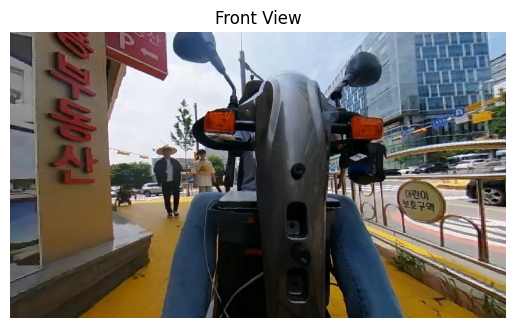

In [9]:
# Convert ERP to front view
theta = np.deg2rad(0)  # Convert degrees to radians
hfov = np.deg2rad(120)  # Convert degrees to radians
vfov = np.deg2rad(90)  # Convert degrees to radians
front_view = erp2rect(erp_image, theta, hfov, vfov)

# Display the front view image
plt.imshow(front_view)
plt.title('Front View')
plt.axis('off')
plt.show()

C:\Users\gibeom\AppData\Local\Temp\ipykernel_20816\2102559259.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  D = f / np.tan(phi)


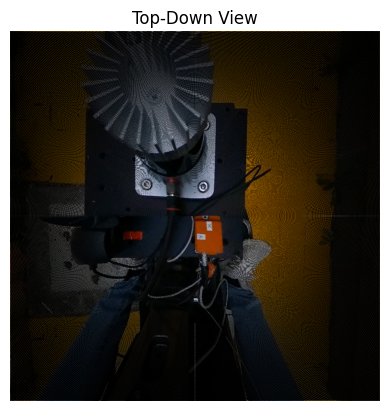

In [48]:
# Updated function to handle the edge cases where D becomes infinity
def erp2topdown(src, hfov, vfov):
    W, H = src.shape[1], src.shape[0]  # ERP image resolution
    f = W / (2 * np.pi)  # Focal length, the radius of the sphere
    
    # Topdown image resolution
    W_prime = int(2 * f * np.tan(hfov / 2) + 0.5)
    H_prime = int(2 * f * np.tan(vfov / 2) + 0.5)
    cx_prime, cy_prime = W_prime // 2, H_prime // 2  # Center of the topdown image
    
    dst = np.zeros((H_prime, W_prime, 3), dtype=np.uint8)  # Destination image
    
    cx, cy = W // 2, H // 2  # Center of the ERP image
    
    max_D = W_prime  # Max distance to prevent infinity value
    
    for y in range(H):
        phi = (y - cy) * np.pi / H  # Vertical angle
        D = f / np.tan(phi)
        if abs(D) > max_D:
            continue        
        
        for x in range(W):
            theta = (x - cx) * 2 * np.pi / W  # Horizontal angle
            x_prime = int(cx_prime + D * np.sin(theta))
            y_prime = int(cy_prime - D * np.cos(theta))
            
            # Clamping the coordinates to be within the valid range
            x_prime = max(0, min(x_prime, W_prime - 1))
            y_prime = max(0, min(y_prime, H_prime - 1))
            
            dst[y_prime, x_prime] = src[y, x]
    
    return dst

# Retry converting ERP to top-doqlsmswn view
hfov_topdown, vfov_topdown = np.deg2rad(120), np.deg2rad(120)
topdown_view = erp2topdown(erp_image, hfov_topdown, vfov_topdown)

# Display the updated top-down view image
plt.imshow(topdown_view)
plt.title('Top-Down View')
plt.axis('off')
plt.show()


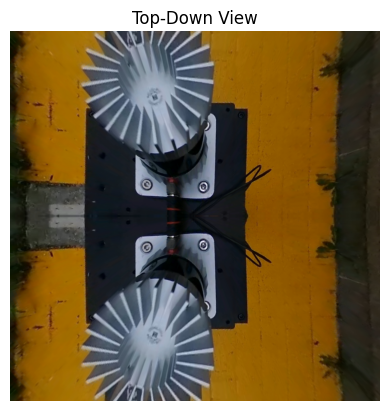

In [44]:
def bilinear_interpolation(img, x, y):
    x0 = int(x)
    y0 = int(y)
    x1 = min(x0 + 1, img.shape[1] - 1)
    y1 = min(y0 + 1, img.shape[0] - 1)

    P00 = img[y0, x0]
    P01 = img[y1, x0]
    P10 = img[y0, x1]
    P11 = img[y1, x1]

    dx = x - x0
    dy = y - y0
    
    interpolated_value = (1 - dx) * (1 - dy) * P00 + \
                         dx * (1 - dy) * P10 + \
                         (1 - dx) * dy * P01 + \
                         dx * dy * P11

    return interpolated_value.astype(np.uint8)

def erp2topdown(src, hfov, vfov):
    W, H = src.shape[1], src.shape[0]  # ERP image resolution
    f = W / (2 * np.pi)  # Focal length, the radius of the sphere
    
    # Topdown image resolution
    W_prime = int(2 * f * np.tan(hfov / 2) + 0.5)
    H_prime = int(2 * f * np.tan(vfov / 2) + 0.5)
    cx_prime, cy_prime = W_prime // 2, H_prime // 2  # Center of the topdown image
    
    cx, cy = W // 2, H // 2  # Center of the ERP image
    
    top_view = np.zeros((H_prime, W_prime, 3), dtype=np.uint8)  # Destination image
    
    for y_prime in range(H_prime):
        for x_prime in range(W_prime):
            D = np.sqrt((x_prime - cx_prime)**2 + (y_prime - cy_prime)**2)
            
            if D == 0:
                top_view[y_prime, x_prime] = src[cy, cx]
                continue
            
            theta = np.arcsin((x_prime - cx_prime) / D)
            phi = np.arctan(f / D)
            
            # Correcting the calculation of erp_x and erp_y
            erp_x = ((theta + np.pi) * W) / (2 * np.pi)
            erp_y = (phi + np.pi / 2) * H / np.pi
            
            # Ensure the coordinates are within the valid range
            erp_x = np.clip(erp_x, 0, W - 1)
            erp_y = np.clip(erp_y, 0, H - 1)
            
            top_view[y_prime, x_prime] = bilinear_interpolation(src, erp_x, erp_y)
    
    return top_view


# Retry converting ERP to top-doqlsmswn view
hfov_topdown, vfov_topdown = np.deg2rad(120), np.deg2rad(120)
topdown_view = erp2topdown(erp_image, hfov_topdown, vfov_topdown)

# Display the updated top-down view image
plt.imshow(topdown_view)
plt.title('Top-Down View')
plt.axis('off')
plt.show()


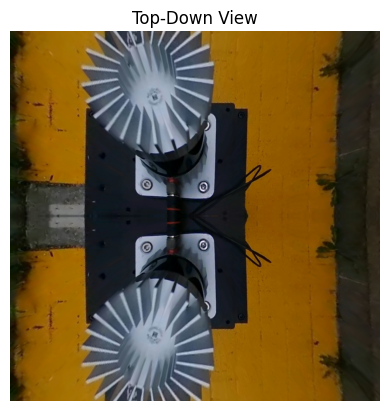

In [54]:
def bilinear_interpolation(img, x, y):
    x0 = int(x)
    y0 = int(y)
    x1 = min(x0 + 1, img.shape[1] - 1)
    y1 = min(y0 + 1, img.shape[0] - 1)

    P00 = img[y0, x0]
    P01 = img[y1, x0]
    P10 = img[y0, x1]
    P11 = img[y1, x1]

    dx = x - x0
    dy = y - y0
    
    interpolated_value = (1 - dx) * (1 - dy) * P00 + \
                         dx * (1 - dy) * P10 + \
                         (1 - dx) * dy * P01 + \
                         dx * dy * P11

    return interpolated_value.astype(np.uint8)





    for y in range(H):
        phi = (y - cy) * np.pi / H  # Vertical angle
        D = f / np.tan(phi)
        if abs(D) > max_D:
            continue        
        
        for x in range(W):
            theta = (x - cx) * 2 * np.pi / W  # Horizontal angle
            x_prime = int(cx_prime + D * np.sin(theta))
            y_prime = int(cy_prime - D * np.cos(theta))
            
            # Clamping the coordinates to be within the valid range
            x_prime = max(0, min(x_prime, W_prime - 1))
            y_prime = max(0, min(y_prime, H_prime - 1))



def erp2topdown(src, hfov, vfov):
    W, H = src.shape[1], src.shape[0]  # ERP image resolution
    f = W / (2 * np.pi)  # Focal length, the radius of the sphere
    
    # Topdown image resolution
    W_prime = int(2 * f * np.tan(hfov / 2) + 0.5)
    H_prime = int(2 * f * np.tan(vfov / 2) + 0.5)
    cx_prime, cy_prime = W_prime // 2, H_prime // 2  # Center of the topdown image
    
    cx, cy = W // 2, H // 2  # Center of the ERP image
    
    top_view = np.zeros((H_prime, W_prime, 3), dtype=np.uint8)  # Destination image
    
    for y_prime in range(H_prime):
        for x_prime in range(W_prime):
            D = np.sqrt((x_prime - cx_prime)**2 + (y_prime - cy_prime)**2)
            
            if D == 0:
                top_view[y_prime, x_prime] = src[cy, cx]
                continue
            
            theta = np.arcsin((x_prime - cx_prime) / D)
            phi = np.arctan(f / D)
            
            # Correcting the calculation of erp_x and erp_y
            erp_x = ((theta + np.pi) * W) / (2 * np.pi)
            erp_y = (phi + np.pi / 2) * H / np.pi
            
            top_view[y_prime, x_prime] = bilinear_interpolation(src, erp_x, erp_y)
    
    return top_view


# Retry converting ERP to top-doqlsmswn view
hfov_topdown, vfov_topdown = np.deg2rad(120), np.deg2rad(120)
topdown_view = erp2topdown(erp_image, hfov_topdown, vfov_topdown)

# Display the updated top-down view image
plt.imshow(topdown_view)
plt.title('Top-Down View')
plt.axis('off')
plt.show()


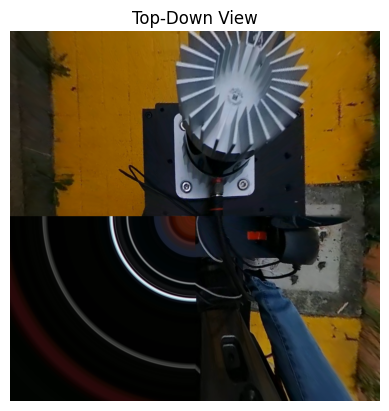

In [64]:
def erp2topdown(src, hfov, vfov):
    W, H = src.shape[1], src.shape[0]  
    f = W / (2 * np.pi)  
    
    W_prime = int(2 * f * np.tan(hfov / 2) + 0.5)
    H_prime = int(2 * f * np.tan(vfov / 2) + 0.5)
    cx_prime, cy_prime = W_prime // 2, H_prime // 2  
    
    cx, cy = W // 2, H // 2  
    
    top_view = np.zeros((H_prime, W_prime, 3), dtype=np.uint8)  
    
    for y_prime in range(H_prime):
        for x_prime in range(W_prime):
            D = np.sqrt((x_prime - cx_prime)**2 + (y_prime - cy_prime)**2)
            
            if D == 0:
                top_view[y_prime, x_prime] = src[cy, cx]
                continue
            
            theta = np.arctan2(cy_prime - y_prime, x_prime - cx_prime) - 0.5 * np.pi
            phi = np.arctan(f / D)
            
            erp_x = (theta + np.pi) * W / (2 * np.pi)
            erp_y = (phi + np.pi / 2) * H / np.pi
            
            erp_x = np.clip(erp_x, 0, W - 1)
            erp_y = np.clip(erp_y, 0, H - 1)
            
            top_view[y_prime, x_prime] = bilinear_interpolation(src, erp_x, erp_y)
    
    return top_view

# Retry converting ERP to top-doqlsmswn view
hfov_topdown, vfov_topdown = np.deg2rad(120), np.deg2rad(120)
topdown_view = erp2topdown(erp_image, hfov_topdown, vfov_topdown)

# Display the updated top-down view image
plt.imshow(topdown_view)
plt.title('Top-Down View')
plt.axis('off')
plt.show()


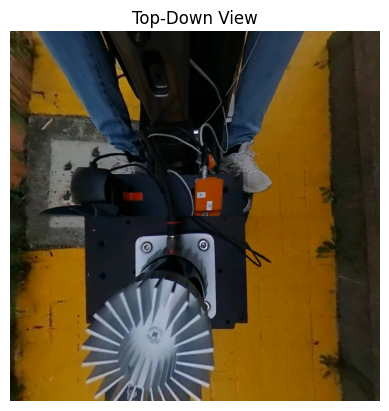

In [66]:
def erp2topdown(src, hfov, vfov):
    W, H = src.shape[1], src.shape[0]  
    f = W / (2 * np.pi)  
    
    W_prime = int(2 * f * np.tan(hfov / 2) + 0.5)
    H_prime = int(2 * f * np.tan(vfov / 2) + 0.5)
    cx_prime, cy_prime = W_prime // 2, H_prime // 2  
    
    cx, cy = W // 2, H // 2  
    
    top_view = np.zeros((H_prime, W_prime, 3), dtype=np.uint8)  
    
    for y_prime in range(H_prime):
        for x_prime in range(W_prime):
            D = np.sqrt((x_prime - cx_prime)**2 + (y_prime - cy_prime)**2)
            
            if D == 0:
                top_view[y_prime, x_prime] = src[cy, cx]
                continue
            
            # Adjusted the order of y_prime and x_prime for the theta calculation
            theta = np.arctan2(x_prime - cx_prime, y_prime - cy_prime)
            phi = np.arctan(f / D)
            
            erp_x = (theta + np.pi) * W / (2 * np.pi)
            erp_y = (phi + np.pi / 2) * H / np.pi
            
            erp_x = np.clip(erp_x, 0, W - 1)
            erp_y = np.clip(erp_y, 0, H - 1)
            
            top_view[y_prime, x_prime] = bilinear_interpolation(src, erp_x, erp_y)
    
    return top_view

hfov_topdown, vfov_topdown = np.deg2rad(120), np.deg2rad(120)
topdown_view = erp2topdown(erp_image, hfov_topdown, vfov_topdown)

# Display the updated top-down view image
plt.imshow(topdown_view)
plt.title('Top-Down View')
plt.axis('off')
plt.show()

